<a href="https://colab.research.google.com/github/yiboxu20/MachineLearning/blob/main/Resources/Module2/Kmeans2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
import numpy.linalg as LA

Populating the interactive namespace from numpy and matplotlib


#More on $K$-means




## Determine the optimal $K$

**Elbow method** to determine the optimal value of hyper-parameter $K$:

- Run Lloyd's algorithm over a loop for an increasing number of clusters $K$

- Plot the minimum of distortion value vs. number of clusters $K$. Note the minimum of distortion value decreases as $K$ increases.

- Select the value of $k$ at the elbow, i.e., the point after which the minimum of distortion value starts to decrease slowly.

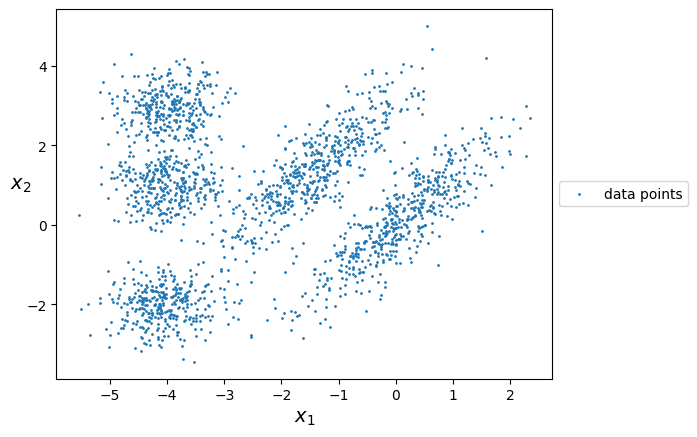

In [2]:
 #@title  Generate data

 from sklearn.datasets import make_blobs

def plot_clusters(X,  centroids=array([[0,0]])):
    plt.scatter(X[:, 0], X[:, 1],  s=1, label='data points')
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    if centroids[0].all():
      plt.scatter(centroids[:-1, 0], centroids[:-1, 1],
                  color = 'black', label = 'previously selected centroids')
      plt.scatter(centroids[-1, 0], centroids[-1, 1],
                  color = 'red', label = 'next centroid')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

if 0:
    blob_centers = np.array(
        [[ 0.2,  2.3],
         [-1.5 ,  2.3],
         [-2.8,  1.8],
         [-2.8,  2.8],
         [-2.8,  1.3]])
    blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
    X, y = make_blobs(n_samples=2000, centers=blob_centers,
                      cluster_std=blob_std, random_state=7)

if 1:
    # two off-diagonal blobs
    X1, _ = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
    X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
    # three spherical blobs
    blob_centers = np.array(
        [[ -4,  1],
         [-4 ,  3],
         [-4,  -2]])
    s = 0.5
    blob_std = np.array([s, s, s])
    X2, _ = make_blobs(n_samples=1000, centers=blob_centers,
                      cluster_std=blob_std, random_state=7)

    X = np.r_[X1, X2]
    K = 5

figure()
plot_clusters(X)

In [3]:
# much more efficient way
# but hard to interprete
def mykmeans(X, K, max_iter=100):
  # step 0
  centroids = X.copy()
  random.shuffle(centroids)
  centroids = centroids[:K]

  distortion_list = []
  for i in range(max_iter):
    # step 1
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    distortion_list.append(sum(np.min(distances, axis=0)))
    closest   = argmin(distances, axis=0)
    centroids_old = centroids
    # step 2
    centroids = array([X[closest==k].mean(axis=0) for k in range(K)])
    # step 3
    if sum(centroids-centroids_old) == 0.:
     # print('Number of iteration is ', i+1)
      break

  return centroids, closest, distortion_list



In [6]:
import time

start    = time.time()
Ks       = [i for i in range(2,13)]
L        = size(Ks)
max_iter = 20
distortion_Ks = empty(L)
for idx, k in enumerate(Ks):
  #print('k is ', k)
  distortion_curr_Ks = empty(max_iter)
  for j in range(max_iter):
    centroids, closest, distortion_list = mykmeans(X,k, max_iter=100)
    distortion_curr_Ks[j] = distortion_list[-1]

  distortion_Ks[idx]   = min(distortion_curr_Ks)

print(f'elapsed: {time.time() - start}')

elapsed: 8.131105661392212


Text(0.5, 0, 'k')

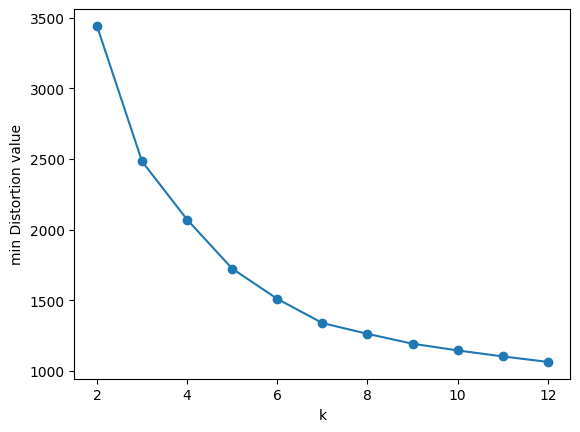

In [7]:
scatter(Ks,distortion_Ks)
plot(Ks,distortion_Ks)
ylabel('min Distortion value')
xlabel('k')

## Sensitive to the initialization of the centroids
1. Repeat K-means: Repeating the algorithm and initialization of centroids several times (10 times) and pick the one has the smallest distortion value.

2. $K$-means++ (Arthur \& Vassilvitskii '07): it is a **smart** centroid initialization technique.


### $K$-means++: improved initialization

It is a probabilistic initialization method for Lloyd's algorithm by **spreading out** the $K$ initial centroids.

- **Step 1**: Choose the first centroid uniformly at random from the data samples.

- **Step 2**: For each data point compute its distance from the nearest, previously chosen centroid.

- **Step 3**: Select the next centroid from the data points such that the probability of choosing a point as centroid is directly proportional to its distance from the nearest, previously chosen centroid. (i.e. the point having maximum distance from the nearest centroid is most likely to be selected next as a centroid)

- Repeat steps 2 and 3 until $K$ centroids have been sampled.

- proceed using standard Lloyd's algorithm with these new initialization.


At iteration $t$, we pick the next cluster center to be $\mathbf{x}^{(i)}$ with probability
$$p(\mu_t=\mathbf{x}^{(i)}) = \frac{D_{t-1}(\mathbf{x}^{(i)})^2}{\sum_{j=1}^N D_{t-1}(\mathbf{x}^{(j)})^2} $$

where
$$D_{t-1}(\mathbf{x}) = \min_{j=1}^{t-1}\|\mathbf{x}-\mu_j\|_2 $$
Thus points that are far away from a centroid are
more likely to be picked, thus reducing the distortion.

This simple trick provides th provable improvement in the distortion value, although a global minimum is not guaranteed. (the recontruction error is never more than $O(\log K)$ worse than optimal).

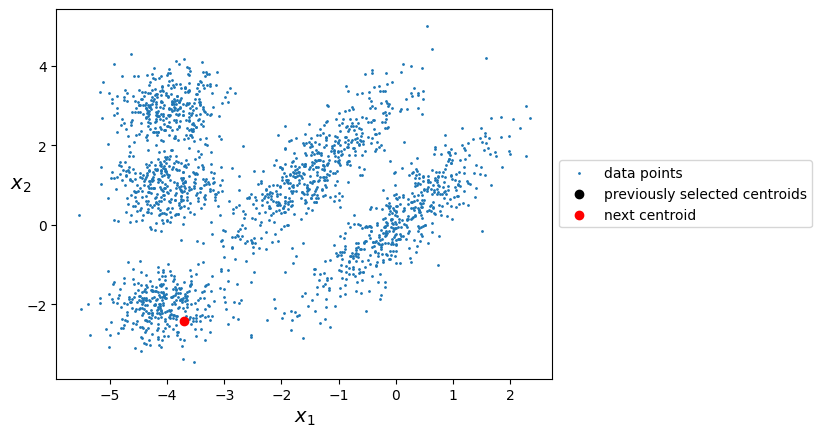

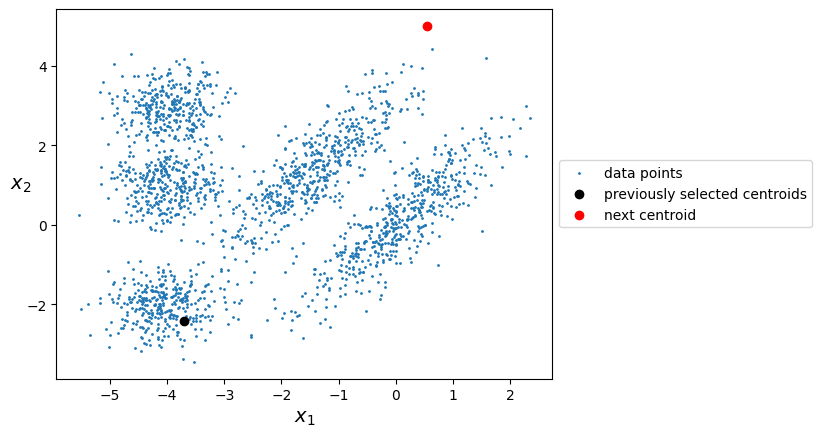

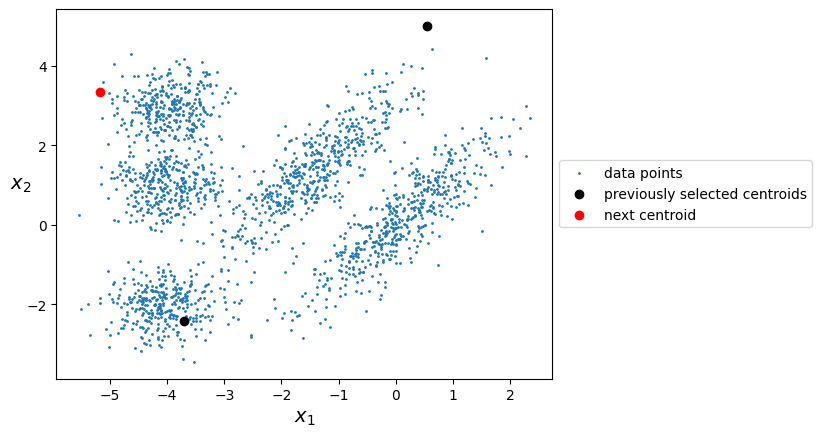

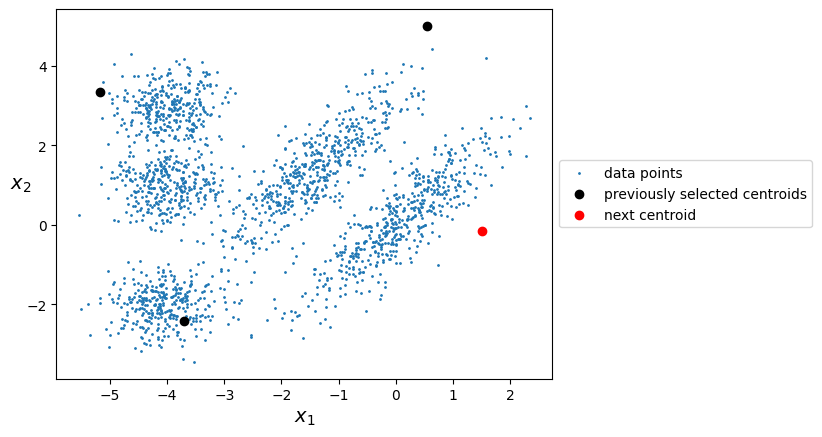

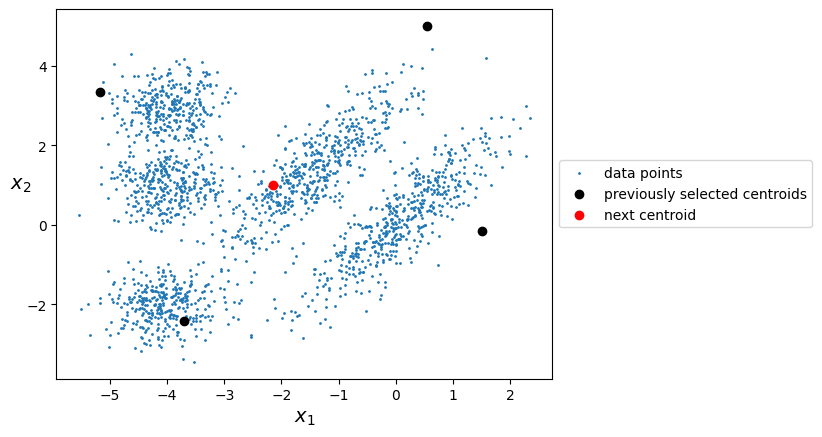

In [14]:
def euclidean_distance(x1, x2):
    return sqrt(sum((x1 - x2) ** 2))

# initialization for Kmeans++ algorithm
def initialize(X, K):

    ## Step 1: initialize the centroids list and add
    ## a randomly selected data point to the list
    n_samples, n_features = X.shape
    random_sample_idxs = random.choice(n_samples, 1, replace=False)
    centroids = X[random_sample_idxs,:]
    plot_clusters(X,centroids)

    ## compute remaining K - 1 centroids
    for c_id in range(K - 1):
        ## Step 2: initialize a list to store distances of data
        ## points from nearest centroid
        ## compute distance of 'point' from each of the previously
        ## selected centroid and store the minimum distance
        dist = zeros(n_samples)
        for idx, sample in enumerate(X):
          distances     = [euclidean_distance(sample, point) for point in centroids]
          dist[idx]     = min(distances)

        ## Step 3: select data point with maximum distance as our next centroid
        next_centroid = X[argmax(dist), :]
        centroids=vstack([centroids,next_centroid])
        plot_clusters(X,centroids)

    return centroids



centroids = initialize(X,5)

In [9]:
def plot_kmeans(X,closest, centroids):
    fig, ax = plt.subplots(figsize=(12, 8))
    K = centroids.shape[0]

    for k in range(K):
       point = X[closest==k].T
       ax.scatter(*point)

    for point in centroids:
      ax.scatter(*point, marker="x", color="black", linewidth=2)

    plt.show()

def mykmeans_plus(X, K, centroids, max_iter=100, plot_steps=False):

  distortion_list = []
  for i in range(max_iter):
    # step 1
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    distortion_list.append(sum(np.min(distances, axis=0)))
    closest   = argmin(distances, axis=0)
    centroids_old = centroids
    if plot_steps:
      plot_kmeans(X,closest, centroids)

    # step 2
    centroids = array([X[closest==k].mean(axis=0) for k in range(K)])
    if plot_steps:
      plot_kmeans(X,closest, centroids)
    # step 3
    if sum(centroids-centroids_old) == 0.:
      print('Number of iteration is ', i+1)
      break


  return centroids, closest, distortion_list


In [15]:
centroids, closest, distortion_list = mykmeans_plus(X, 5, centroids, plot_steps=True)

Output hidden; open in https://colab.research.google.com to view.

Note: Although the initialization in $K$-means++ is computationally more expensive than the standard $K$-means algorithm, the run-time for convergence to optimum is drastically reduced for $K$-means++. This is because the centroids that are initially chosen are likely to lie in different clusters already.

## Applications of $K$-means: image compression
Clustering similar pixels!

Using K-means clustering algorithm we can generalize all these colors by their corresponding centroids. Thus, the image is compressed by using centroids only. The following picture has more than 786000 pixels, however I am using only 2 or 4 colors to approximate the image.

[[114 130 145 ... 119 129 137]
 [ 83 104 123 ... 118 134 146]
 [ 68  88 109 ... 119 134 145]
 ...
 [ 98 103 116 ... 144 143 143]
 [ 94 104 120 ... 143 142 142]
 [ 94 106 119 ... 142 141 140]]


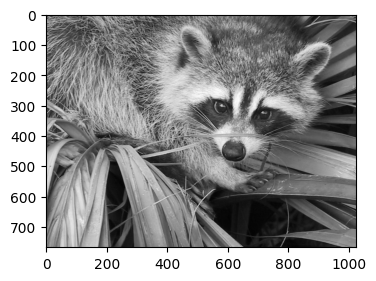

In [ ]:
# I am using sklearn package here
# you are going to acutally implement this in the HW.

from sklearn import cluster
from scipy.datasets import face # Import face from scipy.datasets

face = face(gray=True)
figure(figsize=(4,4))
imshow(face,cmap=plt.cm.gray)
print(face)

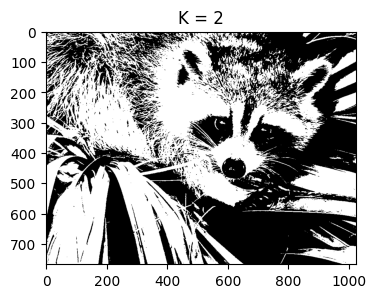

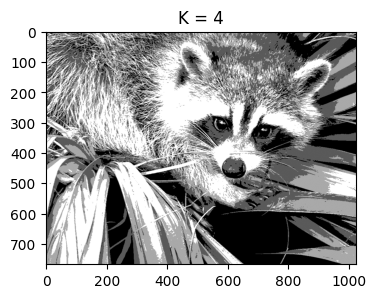

In [ ]:
n_clusters = [2,4]
np.random.seed(0)

X = face.reshape((-1, 1))  # We need an (n_sample, n_feature) array
for n_cluster in n_clusters:
    k_means = cluster.KMeans(n_clusters=n_cluster, n_init=4)
    k_means.fit(X)
    values = k_means.cluster_centers_.squeeze()
    labels = k_means.labels_

    # create an array from labels and values
    face_compressed = np.choose(labels, values)
    face_compressed.shape = face.shape

    # compressed face
    plt.figure(figsize=(4,4))
    plt.title(f'K = {n_cluster}')
    plt.imshow(face_compressed, cmap=plt.cm.gray)

In [88]:
unique(face_compressed.flatten())

array([ 31.5926604 ,  85.96272023, 133.10344344, 184.73010872])

## Limitation of $K$-means
Not suitable for (even with the correct $K$ value)

- non-rounded clusters: like two-moon.

- clusters with different densities.

<img src="https://github.com/yiboxu20/MachineLearning/blob/main/Resources/images/two_moon.png?raw=true" width="600" />

<img src="https://github.com/yiboxu20/MachineLearning/blob/main/Resources/images/densities.png?raw=true" width="600" />


## Summary
- $K$-means is a clustering model aiming to minimize the total within-cluster
variance (i.e., sum of squared Euclidean distances to (nearest) centroids). It runs in $O(NKI)$ time, where $I$ is the number of iterations, but we can reduce the constant factors using various tricks.

- can be efficiently solved by Lloyd's algorithm using alternating
minimization, yet suffers suboptimal solutions due to non-convexity of the
optimization problem.

- standard Lloyd's algorithm can be improved by employing a smart
initialization scheme called $K$-means++, which chooses spread out
centroids at random from the data samples